<a href="https://colab.research.google.com/github/deep1411/Happiness-Predictor/blob/main/Happiness_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The libraries required for the project.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

Data source

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/DS

Mounted at /content/gdrive
/content/gdrive/MyDrive/DS


# Data definition and EDA

The following loads the dataset and provides a look at its size, structure, and summary. This helps in understand what kind of data we're working with and check if anything is missing or unusual.

In [ ]:
data = pd.read_csv('Happiness Predictor/ACME-HappinessSurvey2020.csv')

df = pd.DataFrame(data)

# Display basic info
print(df.shape)
print(df.info())
print(df.describe())

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

(126, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB
None
                Y          X1          X2          X3          X4          X5  \
count  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000   
mean     0.547619    4.333333    2.531746    3.309524    3.746032    3.650794   
std      0.499714    0.800000    1.114892    1.023440    0.875776    1.147641   
min      0.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      0.000000    4.000000    2.000000    3.000000    3.000000    3.000000   
50%      1.000000    5.000000    3.000000  

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy)
customers.

X1 = my order was delivered on time

X2 = contents of my order was as I expected

X3 = I ordered everything I wanted to order

X4 = I paid a good price for my order

X5 = I am satisfied with my courier

X6 = the app makes ordering easy for me

**Exploratory Data analysis:** The charts generated below are to visualize how the data is spread to spot patterns or imbalances in the data.

 - The first chart shows how many people are happy vs. unhappy. We can see that there are slightly more happy customer.

 - Happy customers (Y=1) tend to get their orders on time (X1), feel they got good value (X4), are satisfied with the courier (X5) and find the app easy to use (X6).
 -Unhappy customers (Y=0) are more likely to report late deliveries (X1), feel the price wasn't good (X4), be dissatisfied with the courier (X5) and struggle with the app (X6).
 - Order accuracy (X2) and completeness (X3) don’t show strong differences between happy and unhappy customers.
 - Timely delivery, good pricing, courier satisfaction, and app usability are the biggest drivers of customer happiness while delivery delays, poor pricing perception, courier issues, and a difficult app experience are common pain points for unhappy customers.





From the correlation Matrix we can see that on time delivery, good courier service, and app usability are most positively linked to customer happiness. Order accuracy (X2) has very little effect. No strong correlation between any two variables or factors, which means the varibles are unique and not redundant.

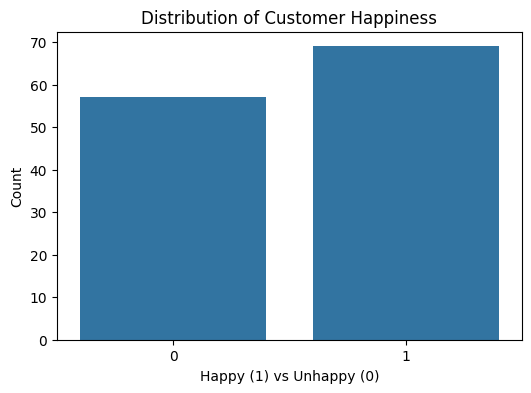

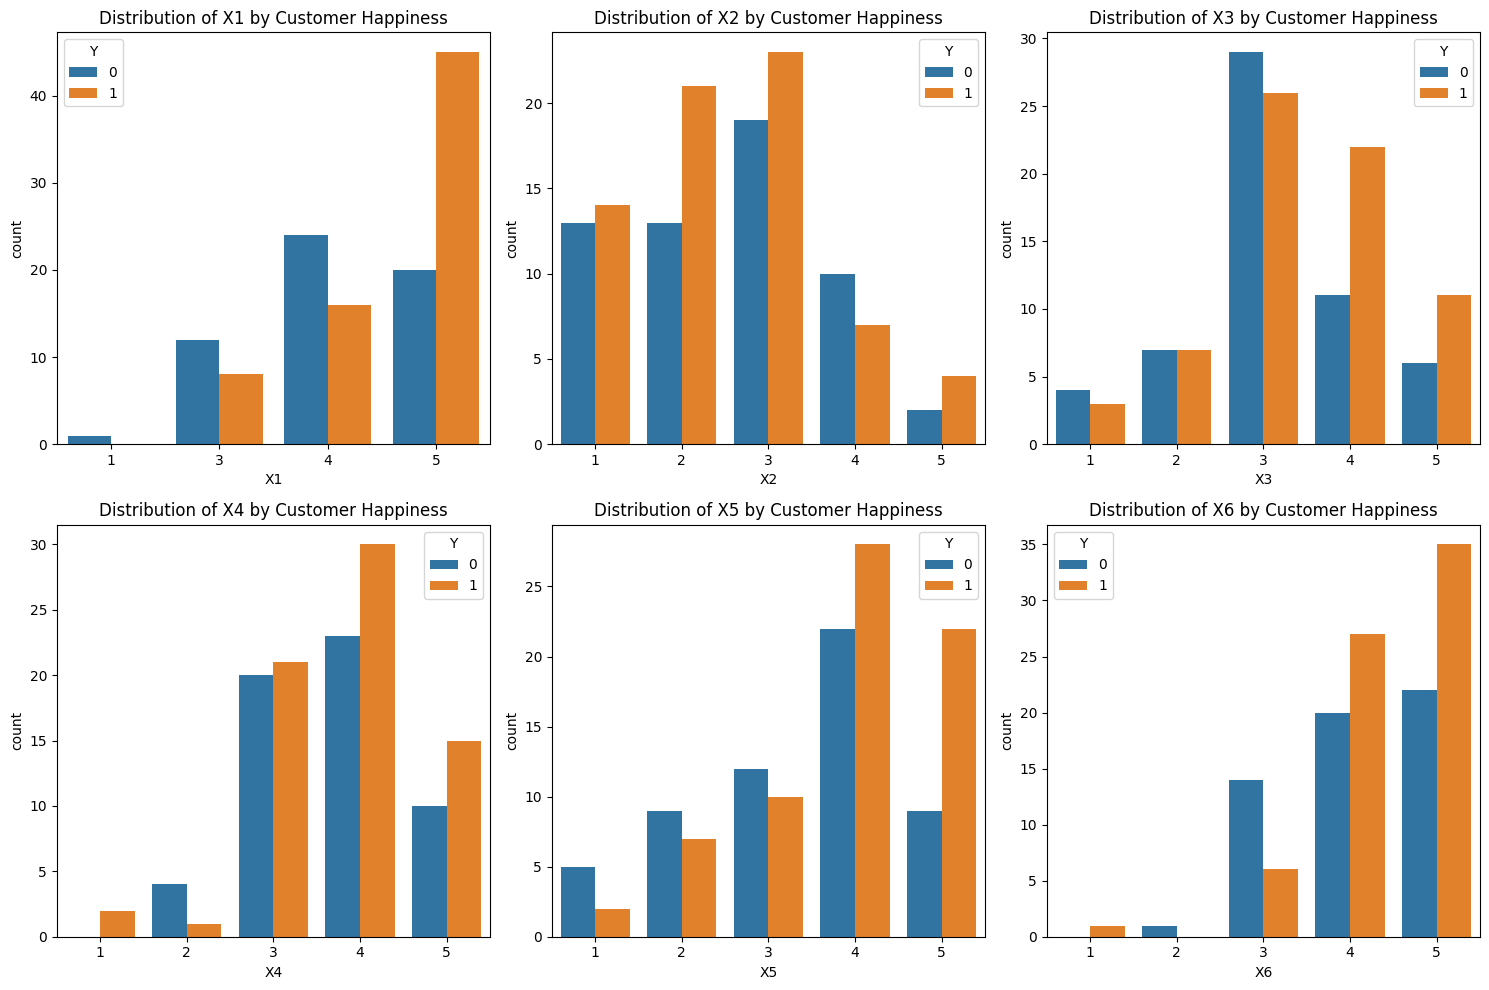

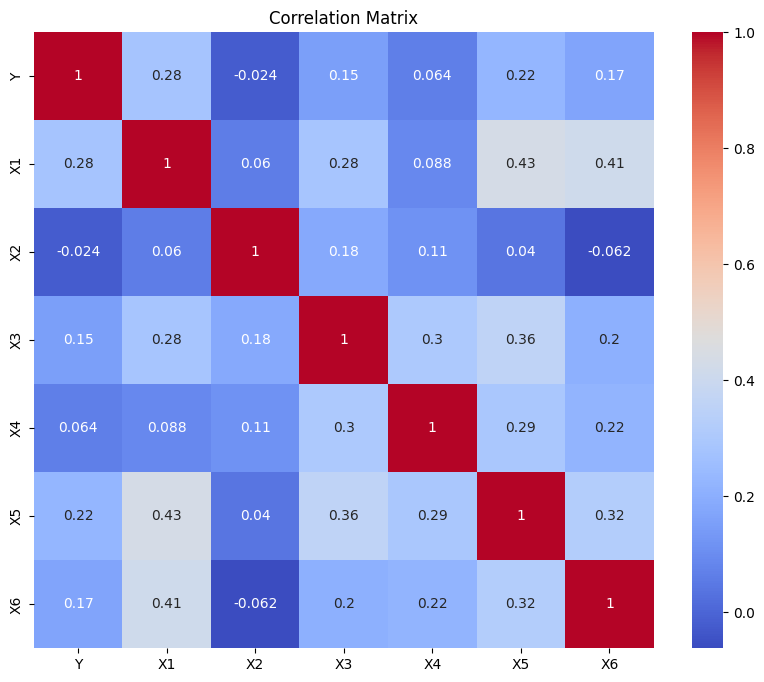

In [ ]:
# Distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='Y', data=df)
plt.title('Distribution of Customer Happiness')
plt.xlabel('Happy (1) vs Unhappy (0)')
plt.ylabel('Count')
plt.show()

# Distribution of features
plt.figure(figsize=(15, 10))
for i, col in enumerate(['X1', 'X2', 'X3', 'X4', 'X5', 'X6']):
    plt.subplot(2, 3, i+1)
    sns.countplot(x=col, hue='Y', data=df)
    plt.title(f'Distribution of {col} by Customer Happiness')
plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Since, the split between happy and unhappy customers is fairly small and both have significatant data points relatively. For this project, rather than focusing on what makes the customers happy, we'll focus on what is making customers unhappy and potentially find actionable attribute(s) that can improve customer satisfaction for business productivity.

# Data Split

Generates a random number between 1000 and 9999.

Experimented with different random seeds during model selection and preliminary model testing phase. Seed = 5638 yeilded fair resuts.

In [ ]:
import random

#seed = random.randint(1000, 9999)
seed = 5638
print(seed)

5638


The following splits the data into training and validation sets, then scaled the feature values to ensure fair input for certain models.

In [ ]:
# Split features and target
X = df.drop('Y', axis=1)
y = df['Y']


# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=seed)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Model selection and preliminary testing.

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

Used the Lazypredict to automatically train and compare several machine learning models to find the optimal models to further train. From 20 runs with random seed, the top five models are LGBM, XGB, Bagging, Random Trees and Random Forest classifiers.

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None )
models,predictions = clf.fit(X_train_scaled, X_val_scaled, y_train, y_val)
models

100%|██████████| 32/32 [00:02<00:00, 14.30it/s]

[LightGBM] [Info] Number of positive: 58, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580000 -> initscore=0.322773
[LightGBM] [Info] Start training from score 0.322773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.85,0.85,0.85,0.85,0.04
BernoulliNB,0.77,0.79,0.79,0.77,0.02
BaggingClassifier,0.69,0.71,0.71,0.69,0.06
NearestCentroid,0.69,0.70,0.70,0.69,0.02
RandomForestClassifier,0.62,0.64,0.64,0.61,0.27
NuSVC,0.62,0.64,0.64,0.61,0.02
XGBClassifier,0.62,0.62,0.62,0.62,0.99
ExtraTreesClassifier,0.58,0.61,0.61,0.56,0.20
DecisionTreeClassifier,0.58,0.61,0.61,0.56,0.02


For the following model runs, the focus is on Recall and other metrics for the class 0, unhapy customers while considering the overall model accuraccy.

Random forest after 10 runs with random seed:
precision = 0.583, recall = 0.561, f1-score = 0.559

In [ ]:
rf_model = RandomForestClassifier(random_state=seed)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=1608)

In [ ]:
# Predictions
y_pred_rf = rf_model.predict(X_val)

In [ ]:
# Classification Report
print("Random Forest Classification Report:\n", classification_report(y_val, y_pred_rf))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.67      0.57         9
           1       0.79      0.65      0.71        17

    accuracy                           0.65        26
   macro avg       0.64      0.66      0.64        26
weighted avg       0.69      0.65      0.66        26



Extra Trees after 10 runs with random seed: precision = 0.517, recall = 0.462, f1-score = 0.47

In [ ]:
extra_trees_model = ExtraTreesClassifier(random_state=seed)
extra_trees_model.fit(X_train, y_train)

ExtraTreesClassifier(random_state=4885)

In [ ]:
y_pred_extra_trees = extra_trees_model.predict(X_val)

In [ ]:
print("Extra Trees Classification Report:\n", classification_report(y_val, y_pred_extra_trees))

Extra Trees Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.67      0.52         9
           1       0.75      0.53      0.62        17

    accuracy                           0.58        26
   macro avg       0.59      0.60      0.57        26
weighted avg       0.64      0.58      0.59        26



Bagging after 10 runs with random seed: precision = 0.563, recall = 0.506, f1-score = 0.522

In [ ]:
bagging_model = BaggingClassifier(random_state=seed)
bagging_model.fit(X_train, y_train)

BaggingClassifier(random_state=5768)

In [ ]:
y_pred_bagging = bagging_model.predict(X_val)

In [ ]:
print("Bagging Classification Report:\n", classification_report(y_val, y_pred_bagging))

Bagging Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.30      0.40        10
           1       0.67      0.88      0.76        16

    accuracy                           0.65        26
   macro avg       0.63      0.59      0.58        26
weighted avg       0.64      0.65      0.62        26



In [ ]:
import xgboost as xgb

Bagging after 10 runs with random seed: precision = 0.577, recall = 0.523, f1-score = 0.538

In [ ]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=seed)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=5008, ...)

In [ ]:
y_pred_xgb = xgb_model.predict(X_val)

In [ ]:
print("XGBoost Classification Report:\n", classification_report(y_val, y_pred_xgb))

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       0.69      0.69      0.69        16

    accuracy                           0.62        26
   macro avg       0.59      0.59      0.59        26
weighted avg       0.62      0.62      0.62        26



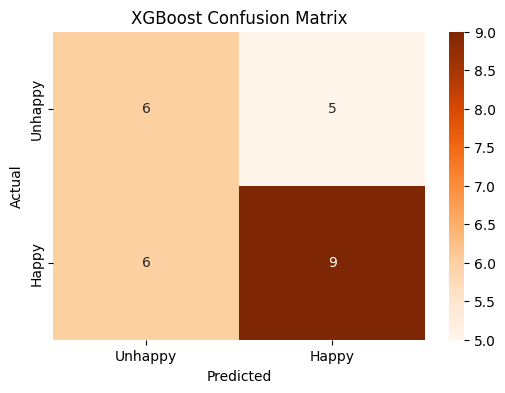

In [ ]:
cm_xgb = confusion_matrix(y_val, y_pred_xgb)
plt.figure(figsize=(6,4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', xticklabels=['Unhappy', 'Happy'], yticklabels=['Unhappy', 'Happy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

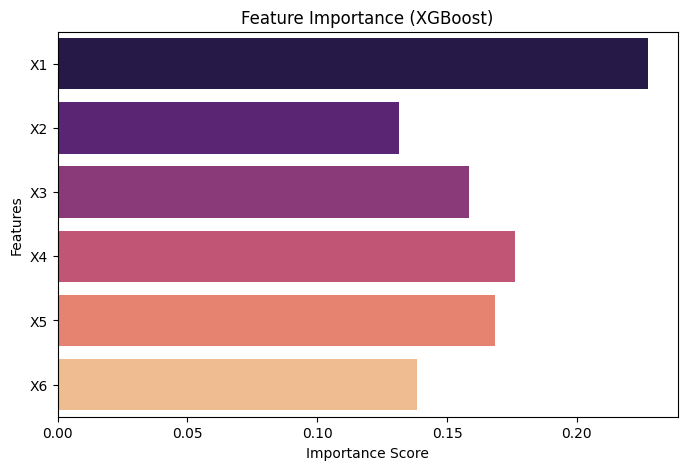

In [ ]:
feature_importances_xgb = xgb_model.feature_importances_

plt.figure(figsize=(8,5))
sns.barplot(x=feature_importances_xgb, y=feature_names, palette='magma')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance (XGBoost)')
plt.show()

In [ ]:
import lightgbm as lgb

LGBM after 10 runs with random seed: precision = 0.619, recall = 0.627, f1-score = 0.612. LGBM classifier has the highest average results compared to the other 4 models tested.


In [ ]:
lgbm_model = lgb.LGBMClassifier(random_state=seed)
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 52, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 94, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553191 -> initscore=0.213574
[LightGBM] [Info] Start training from score 0.213574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMClassifier(random_state=5638)

In [ ]:
y_pred = lgbm_model.predict(X_val)

In [ ]:
print("Classification Report:\n", classification_report(y_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.80      0.65        15
           1       0.70      0.41      0.52        17

    accuracy                           0.59        32
   macro avg       0.62      0.61      0.58        32
weighted avg       0.63      0.59      0.58        32



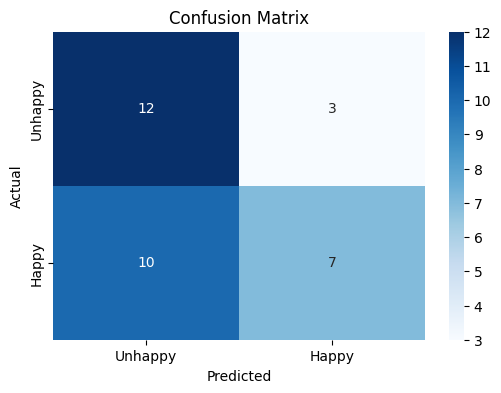

In [ ]:
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unhappy', 'Happy'], yticklabels=['Unhappy', 'Happy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Ensemble Stacking

In [ ]:
from sklearn.linear_model import LogisticRegression

Using the 3 models from the above testing as base models for stacking ensemble to see if there is any improvement with model accuracy. LGBM, XGB and Random Forest classifiers.

 - Unhappy Customers: Precision = 0.62 Recall = 0.67 F1 score = 0.65
 - Happy Customers: Precision = 0.69 Recall = 0.65 F1 score = 0.67
 - True negatives = 10/16 True positives = 11/16
 - Accuracy = 65.625 %

In [ ]:
base_models = [
    ('lgbm', lgb.LGBMClassifier(random_state=seed)),
    ('xgb', xgb.XGBClassifier(random_state=seed)),
    ('rf', RandomForestClassifier(random_state=seed)),
]

In [ ]:
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

Testing with a different set of base models. LGBM, ExtraTrees and CatBoost classifiers.

 - Unhappy Customers: Precision = 0.69 Recall = 0.73 F1 score = 0.71
 - Happy Customers: Precision = 0.75 Recall = 0.71 F1 score = 0.73
 - True negatives = 11/16 True positives = 12/16
 - Accuracy = 71.875 %
 - LGBM, ExtraTrees and CatBoost classifiers as base models perform better than the combination of LGBM, XGB and Random Forest classifiers.

In [ ]:
base_models = [
    ('lgbm', lgb.LGBMClassifier(random_state=seed)),
    ('extratrees', ExtraTreesClassifier(random_state=seed)),
    ('catboost', CatBoostClassifier(verbose=0, random_state=seed))
]

Tried different combinations of the 5 models together from previous two runs but the results are similar or worse than the initial base models above.

In [ ]:
base_models = [
    ('lgbm', lgb.LGBMClassifier(random_state=seed)),
    ('xgb', xgb.XGBClassifier(random_state=seed)),
    ('rf', RandomForestClassifier(random_state=seed)),
    ('extratrees', ExtraTreesClassifier(random_state=seed)),
    ('catboost', CatBoostClassifier(verbose=0, random_state=seed))
]

Using logistic regression classifier as the final estimator.

In [ ]:
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
stacking_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 51, number of negative: 43
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 94, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542553 -> initscore=0.170626
[LightGBM] [Info] Start training from score 0.170626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

StackingClassifier(estimators=[('lgbm', LGBMClassifier(random_state=8941)),
                               ('extratrees',
                                ExtraTreesClassifier(random_state=8941)),
                               ('catboost',
                                <catboost.core.CatBoostClassifier object at 0x7ccd3909b490>)],
                   final_estimator=LogisticRegression())

In [ ]:
y_pred_stacking = stacking_model.predict(X_val)
print("Stacking Classifier Classification Report:\n", classification_report(y_val, y_pred_stacking))

Stacking Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.43      0.50        14
           1       0.64      0.78      0.70        18

    accuracy                           0.62        32
   macro avg       0.62      0.60      0.60        32
weighted avg       0.62      0.62      0.61        32



Text(0.5, 1.0, 'Stacking Classifier Confusion Matrix')

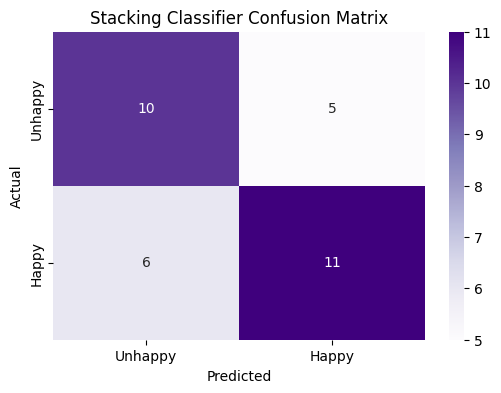

In [ ]:
cm_stacking = confusion_matrix(y_val, y_pred_stacking)
plt.figure(figsize=(6,4))
sns.heatmap(cm_stacking, annot=True, fmt='d', cmap='Purples', xticklabels=['Unhappy', 'Happy'], yticklabels=['Unhappy', 'Happy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Stacking Classifier Confusion Matrix')

# Ensemble Voting

Using the the similar base models as Stacking for Voting ensemble to see if there is any improvement with model accuracy.

 - Unhappy Customers: Precision = 0.69 Recall = 0.79 F1 score = 0.73
 - Happy Customers: Precision = 0.81 Recall = 0.72 F1 score = 0.76
 - Soft - True negatives = 11/16 True positives = 13/16
 - Accuracy = 75 %
 - Below set of base models with voting ensemble seem to perform the best so far.

In [ ]:
base_models = [
    ('lgbm', lgb.LGBMClassifier(random_state=seed)),
    ('xgb', xgb.XGBClassifier(random_state=seed)),
    ('rf', RandomForestClassifier(random_state=seed)),
]

 - Unhappy Customers: Precision = 0.61 Recall = 0.79 F1 score = 0.69
 - Happy Customers: Precision = 0.79 Recall = 0.61 F1 score = 0.69
 - Soft - True negatives = 11/18 True positives = 11/14
 - Accuracy = 68.75 %

In [ ]:
base_models = [
    ('lgbm', lgb.LGBMClassifier(random_state=seed)),
    ('extratrees', ExtraTreesClassifier(random_state=seed)),
    ('catboost', CatBoostClassifier(verbose=0, random_state=seed))
]

 - Unhappy Customers: Precision = 0.67 Recall = 0.71 F1 score = 0.69
 - Happy Customers: Precision = 0.76 Recall = 0.72 F1 score = 0.74
 - Soft - True negatives = 10/15 True positives = 13/17
 - Accuracy = 71.875 %

In [ ]:
base_models = [
    ('lgbm', lgb.LGBMClassifier(random_state=seed)),
    ('xgb', xgb.XGBClassifier(random_state=seed)),
    ('rf', RandomForestClassifier(random_state=seed)),
    ('extratrees', ExtraTreesClassifier(random_state=seed)),
    ('catboost', CatBoostClassifier(verbose=0, random_state=seed))
]

Used 'soft' voting as it performed better than hard voting for the above base models.

In [ ]:
voting_ensemble = VotingClassifier(base_models, voting='soft')
voting_ensemble.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 51, number of negative: 43
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 94, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542553 -> initscore=0.170626
[LightGBM] [Info] Start training from score 0.170626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

VotingClassifier(estimators=[('lgbm', LGBMClassifier(random_state=5683)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=No...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=5683, ...)),
                             ('rf', RandomForestClassifier(random_state=5683)),
                             ('extratrees',
                              ExtraTreesClassifier(random_state=5683)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7ccd33e18a50>)])

In [ ]:
y_pred_voting = voting_ensemble.predict(X_val)
print("Voting Ensemble Classification Report:")
print(classification_report(y_val, y_pred_voting))

Voting Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.79      0.67        14
           1       0.77      0.56      0.65        18

    accuracy                           0.66        32
   macro avg       0.67      0.67      0.66        32
weighted avg       0.69      0.66      0.65        32



Text(0.5, 1.0, 'Voting Classifier Confusion Matrix')

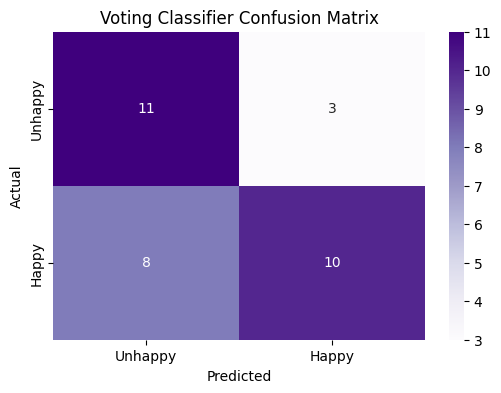

In [ ]:
cm_voting = confusion_matrix(y_val, y_pred_voting)
plt.figure(figsize=(6,4))
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Purples', xticklabels=['Unhappy', 'Happy'], yticklabels=['Unhappy', 'Happy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Voting Classifier Confusion Matrix')

# Feature selection

Performing feature selection to further focus on key features that drive customer unhappiness. Using Recursive Feature Elimination (RFE) on the top three performing models: LGBM, Random Forest and XGB classifier. Then use the voting ensemble model again to test the performance.

In [ ]:
from sklearn.feature_selection import RFE

Using RFE with LGBM as the base model.
 - Features selected: ['X1', 'X2', 'X3']
 - After running the voting classifier:
    - Unhappy Customers: Precision = 0.53 Recall = 0.60 F1 score = 0.56
    - Happy Customers: Precision = 0.60 Recall = 0.53 F1 score = 0.56

In [ ]:
estimator_for_rfe = lgb.LGBMClassifier(random_state=seed)
rfe_selector = RFE(estimator=estimator_for_rfe, n_features_to_select=3, step=1)
rfe_selector.fit(X_train, y_train)

selected_features = X_train.columns[rfe_selector.get_support()]
print("Selected top 3 features by RFE:", selected_features.tolist())

[LightGBM] [Info] Number of positive: 52, number of negative: 42
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 94, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553191 -> initscore=0.213574
[LightGBM] [Info] Start training from score 0.213574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

In [ ]:
X_train_rfe = rfe_selector.transform(X_train)
X_val_rfe = rfe_selector.transform(X_val)

In [ ]:
voting_ensemble = VotingClassifier(base_models, voting='soft')
voting_ensemble.fit(X_train_rfe, y_train)

[LightGBM] [Info] Number of positive: 52, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16
[LightGBM] [Info] Number of data points in the train set: 94, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553191 -> initscore=0.213574
[LightGBM] [Info] Start training from score 0.213574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

VotingClassifier(estimators=[('lgbm', LGBMClassifier(random_state=5638)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=No...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=5638, ...)),
                             ('rf', RandomForestClassifier(random_state=5638))],
                 voting='soft')

In [ ]:
y_pred_rfe = voting_ensemble.predict(X_val_rfe)
print("Stacking Ensemble Classification Report with Top 3 RFE features:")
print(classification_report(y_val, y_pred_rfe))

Stacking Ensemble Classification Report with Top 3 RFE features:
              precision    recall  f1-score   support

           0       0.53      0.60      0.56        15
           1       0.60      0.53      0.56        17

    accuracy                           0.56        32
   macro avg       0.56      0.56      0.56        32
weighted avg       0.57      0.56      0.56        32



Using RFE with Random Forest as the base model.
 - Features selected: ['X2', 'X3', 'X5']
 - After running the voting classifier:
    - Unhappy Customers: Precision = 0.53 Recall = 0.67 F1 score = 0.59
    - Happy Customers: Precision = 0.62 Recall = 0.47 F1 score = 0.53

In [ ]:
rf_estimator = RandomForestClassifier(random_state=seed)
rfe_selector = RFE(estimator=rf_estimator, n_features_to_select=3, step=1)
rfe_selector.fit(X_train, y_train)

selected_features = X_train.columns[rfe_selector.get_support()]
print("Selected top 3 features by RFE using Random Forest:", selected_features.tolist())

Selected top 3 features by RFE using Random Forest: ['X2', 'X3', 'X5']


In [ ]:
X_train_rfe = rfe_selector.transform(X_train)
X_val_rfe = rfe_selector.transform(X_val)

In [ ]:
voting_ensemble = VotingClassifier(base_models, voting='soft')
voting_ensemble.fit(X_train_rfe, y_train)

[LightGBM] [Info] Number of positive: 52, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 94, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553191 -> initscore=0.213574
[LightGBM] [Info] Start training from score 0.213574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

VotingClassifier(estimators=[('lgbm', LGBMClassifier(random_state=5638)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=No...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=5638, ...)),
                             ('rf', RandomForestClassifier(random_state=5638))],
                 voting='soft')

In [ ]:
y_pred_voting = voting_ensemble.predict(X_val_rfe)
print("Voting Ensemble Classification Report with top 3 features from RFE:")
print(classification_report(y_val, y_pred_voting))

Voting Ensemble Classification Report with top 3 features from RFE:
              precision    recall  f1-score   support

           0       0.53      0.67      0.59        15
           1       0.62      0.47      0.53        17

    accuracy                           0.56        32
   macro avg       0.57      0.57      0.56        32
weighted avg       0.57      0.56      0.56        32



Using RFE with XGB as the base model.
 - Features selected: ['X1', 'X5', 'X6']
 - After running the voting classifier:
    - Unhappy Customers: Precision = 0.63 Recall = 0.80 F1 score = 0.71
    - Happy Customers: Precision = 0.77 Recall = 0.59 F1 score = 0.67
 - This set of features seem to produce the best results compared to the previous two set of features.

In [ ]:
rf_estimator = xgb.XGBClassifier(random_state=seed)
rfe_selector = RFE(estimator=rf_estimator, n_features_to_select=3, step=1)
rfe_selector.fit(X_train, y_train)

selected_features = X_train.columns[rfe_selector.get_support()]
print("Selected top 3 features by RFE using Random Forest:", selected_features.tolist())

Selected top 3 features by RFE using Random Forest: ['X1', 'X5', 'X6']


In [ ]:
X_train_rfe = rfe_selector.transform(X_train)
X_val_rfe = rfe_selector.transform(X_val)

In [ ]:
voting_ensemble = VotingClassifier(base_models, voting='soft')
voting_ensemble.fit(X_train_rfe, y_train)

[LightGBM] [Info] Number of positive: 52, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 94, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553191 -> initscore=0.213574
[LightGBM] [Info] Start training from score 0.213574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

VotingClassifier(estimators=[('lgbm', LGBMClassifier(random_state=5638)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=No...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=5638, ...)),
                             ('rf', RandomForestClassifier(random_state=5638))],
                 voting='soft')

In [ ]:
y_pred_voting = voting_ensemble.predict(X_val_rfe)
print("Voting Ensemble Classification Report with top 3 features from RFE:")
print(classification_report(y_val, y_pred_voting))

Voting Ensemble Classification Report with top 3 features from RFE:
              precision    recall  f1-score   support

           0       0.63      0.80      0.71        15
           1       0.77      0.59      0.67        17

    accuracy                           0.69        32
   macro avg       0.70      0.69      0.69        32
weighted avg       0.70      0.69      0.69        32



# Bayesian optimization

Tested Bayesian optimization to see any improvements but no significant improvents over the previous results.

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import lightgbm as lgb

In [ ]:
def lgb_cv(num_leaves, learning_rate, n_estimators, max_depth):
    num_leaves = int(num_leaves)
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)

    model = lgb.LGBMClassifier(
        num_leaves=num_leaves,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=seed
    )

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return cv_scores.mean()

In [ ]:
pbounds = {
    'num_leaves': (20, 100),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 500),
    'max_depth': (3, 10)
}

In [ ]:
optimizer = BayesianOptimization(
    f=lgb_cv,
    pbounds=pbounds,
    random_state=seed,
    verbose=2
)

# - init_points: number of random initial evaluations
# - n_iter: number of iterations to refine the search
optimizer.maximize(init_points=10, n_iter=25)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
print(optimizer.max)

{'target': np.float64(0.6818713450292397), 'params': {'learning_rate': np.float64(0.2095216314322421), 'max_depth': np.float64(6.7158222294408905), 'n_estimators': np.float64(484.275832182424), 'num_leaves': np.float64(83.91849508551088)}}


In [ ]:
best_params = {
    'learning_rate': 0.2095216314322421,
    'max_depth': int(6.7158222294408905),
    'n_estimators': int(484.275832182424),
    'num_leaves': int(83.91849508551088)
}

optimized_lgbm = lgb.LGBMClassifier(
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    num_leaves=best_params['num_leaves'],
    random_state=seed
)

optimized_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 52, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 94, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553191 -> initscore=0.213574
[LightGBM] [Info] Start training from score 0.213574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMClassifier(learning_rate=0.2095216314322421, max_depth=6, n_estimators=484,
               num_leaves=83, random_state=5638)

In [ ]:
y_pred = optimized_lgbm.predict(X_val)
print("Classification Report:\n", classification_report(y_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.73      0.63        15
           1       0.67      0.47      0.55        17

    accuracy                           0.59        32
   macro avg       0.61      0.60      0.59        32
weighted avg       0.61      0.59      0.59        32



Testing with 3 features.

In [ ]:
optimized_lgbm.fit(X_train_rfe, y_train)

[LightGBM] [Info] Number of positive: 52, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 94, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553191 -> initscore=0.213574
[LightGBM] [Info] Start training from score 0.213574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [ ]:
y_pred2 = optimized_lgbm.predict(X_val_rfe)
print("Classification Report:\n", classification_report(y_val, y_pred2))